# Process Path from VINS-Mono

1. Record the VINS-Mono output. In the Docker container, record a rosbag of the Path generated by VINS.
   ```bash
   cd /user
   rosbag record /pose_graph/pose_graph_path
   ```
2. Take a note of the rosbag name.
3. Interactively use this `process_rosbag_paths` notebook outside the Docker container.


In [76]:
import rosbag
import rospy
import numpy as np
import matplotlib.pyplot as plt
import pytransform3d.transformations as pt
import pytransform3d.rotations as pr
from nav_msgs.msg import Path

# CHANGE THIS HERE TO WHAT YOU RECORDED. It should be in this folder.
ROSBAG_PATH = "2024-09-25-10-13-34.bag"

# Read from this topic
topics = ['/pose_graph/pose_graph_path']
out_path: Path = Path()

# Take the last message from bag
bag = rosbag.Bag(ROSBAG_PATH, 'r')
read_start_time = max(bag.get_start_time(), bag.get_end_time() - 2.0)
read_end_time = bag.get_end_time()

for BAG_THING in bag.read_messages(
        topics=topics,
        start_time=rospy.Time(read_start_time),  # type: ignore
        end_time=rospy.Time(read_end_time)):
    topic, msg, t = BAG_THING  # type: ignore
    assert out_path.poses is not None
    assert msg.poses is not None

    if len(msg.poses) > len(out_path.poses):
        out_path = msg

Visually inspect the trajectory here, checking that the axes are correct. We convert the axes into the Spot Body frame so that the trajectory can be used as an odometry source. Transform obtained from [hydro calibration heaven](https://colab.research.google.com/drive/1OeSwiQ3i96dJy1IX_3CC_Wv-K9xfLp4y?authuser=2#scrollTo=qKLc_cfaKwgj)


Path is in the world frame and has 2167 poses


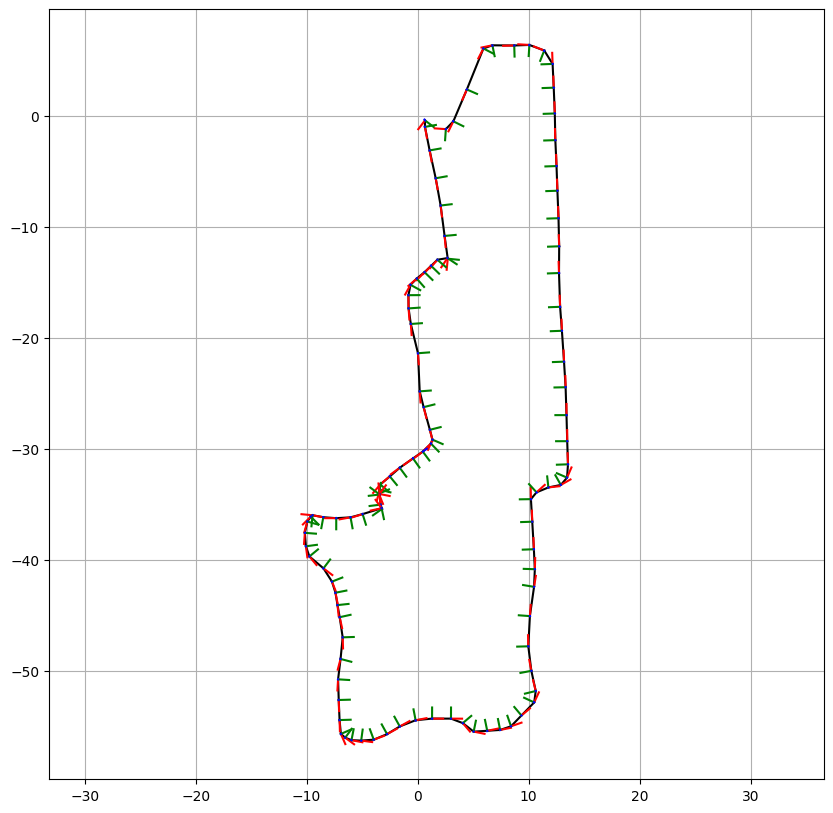

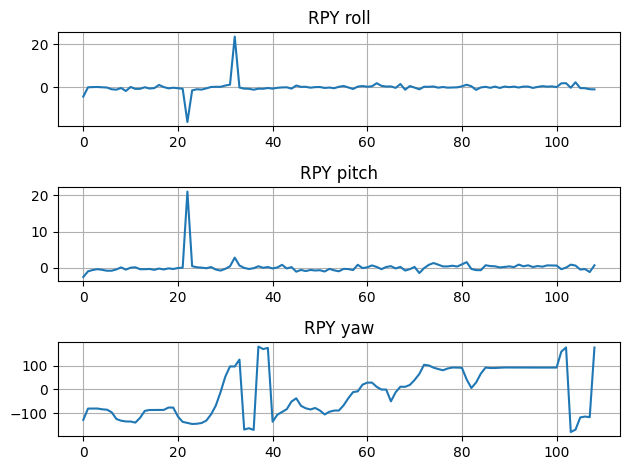

In [80]:
# See number of poses
assert out_path.poses is not None
print(f"Path is in the {out_path.header.frame_id} frame and has {len(out_path.poses)} poses")

# Convert poses from IMU frame to spot body frame for comparison with other odometry sources
T_spotBody_kinectImu = np.array([[-0.996907, -0.009291, -0.078041, 0.480000],
                                 [-0.010696, 0.999788, 0.017599, 0.002000],
                                 [0.077861, 0.018379, -0.996795, 0.115000],
                                 [0.000000, 0.000000, 0.000000, 1.000000]])
T_kinectImu_spotBody = np.linalg.inv(T_spotBody_kinectImu)

timestamps = [pose.header.stamp.to_sec() for pose in out_path.poses]
poses_orig = [pt.transform_from_pq(
    [pose.pose.position.x, pose.pose.position.y, pose.pose.position.z,
     pose.pose.orientation.w, pose.pose.orientation.x, pose.pose.orientation.y, pose.pose.orientation.z])
    for pose in out_path.poses]
poses_trf = [pose @ T_kinectImu_spotBody for pose in poses_orig]

poses_plot = poses_trf[::20]
rpys = [pr.euler_from_matrix(pose[:3, :3], 0, 1, 2, False) for pose in poses_plot]

xs = [pose[0, 3] for pose in poses_plot]
ys = [pose[1, 3] for pose in poses_plot]
dx = [pose[0, 0] for pose in poses_plot]
dy = [pose[1, 0] for pose in poses_plot]

# Plot the path
fig = plt.figure(figsize=(10, 10))
plt.plot(xs, ys, 'k')
for pose in poses_plot:

    x, y = pose[0, 3], pose[1, 3]
    axes_to_name = {0: "x", 1: "y", 2: "z"}
    name_to_color = {"x": "r", "y": "g", "z": "b"}
    for i in range(3):
        dx, dy = pose[0, i], pose[1, i]
        plt.plot([x, x + dx], [y, y + dy], name_to_color[axes_to_name[i]])
plt.grid()
# set equal aspect ratio
plt.axis('equal')

fig, axs = plt.subplots(3, 1)
label = {0: "roll", 1: "pitch", 2: "yaw"}
for i in range(3):
    axs[i].plot([np.rad2deg(rpy[i]) for rpy in rpys])
    axs[i].set_title(f"RPY {label[i]}")
    axs[i].grid()
plt.tight_layout()

plt.show()

Now dump to TUM format


In [82]:
# Dump to TUM
out_file_name = ROSBAG_PATH.replace(".bag", "_tum.txt")
print(f"Dumping to {out_file_name}")

with open(out_file_name, "w") as f:
    for timestamp, pose in zip(timestamps, poses_trf):
        x, y, z = pose[0, 3], pose[1, 3], pose[2, 3]
        qw, qx, qy, qz = pr.quaternion_from_matrix(pose[:3, :3])
        f.write(f"{timestamp} {x} {y} {z} {qx} {qy} {qz} {qw}\n")

Dumping to 2024-09-25-10-13-34_tum.txt
